In [43]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

This jupyter script has been used to concatenate and analyze 

Alignment and Concatenation of subsequent trajectories 

In [3]:
import nglview

In [4]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'


#concatenation 

traj_0 = data_path + "prod_0/step5_prod_0_nbc.xtc"
traj_1 = data_path + "prod_1/step5_prod_1_nbc.xtc"
traj_2 = data_path + "prod_2/step5_prod_2_nbc.xtc"


config_file = data_path + "step5_prod_0.tpr"
concat_traj_file = data_path + "prod_cat.xtc"

conc_traj = mda.Universe(config_file, [traj_0,traj_1, traj_2])
ref_traj = mda.Universe(config_file, traj_0)

ref_traj.trajectory[0]
aligner = AlignTraj(conc_traj,ref_traj,select=sel,filename = concat_traj_file)
aligner.run()

In [5]:
aligned_traj = mda.Universe(config_file, concat_traj_file)

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [6]:
view = nglview.show_mdanalysis(aligned_traj)
view

NGLWidget(max_frame=1702)

                                                            
                                                        RMSD and RMSF 

Text(0, 0.5, 'RMSD')

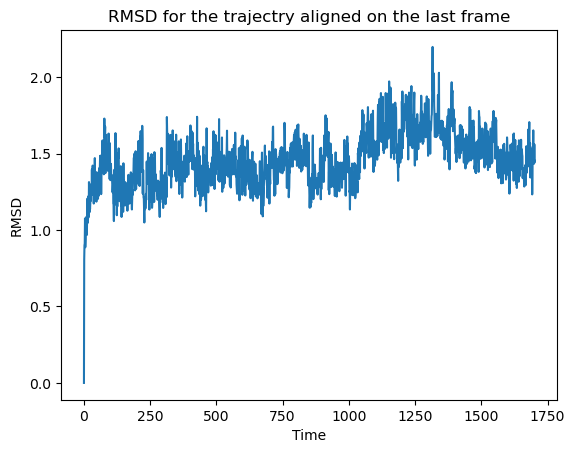

In [7]:
R = RMSD(aligned_traj, ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,2])
plt.xlabel('Time')
plt.ylabel('RMSD')

Text(0, 0.5, 'RMSD')

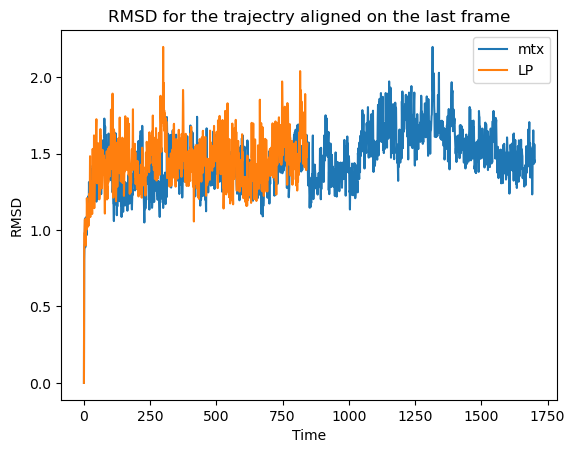

In [8]:
# comparison with lone protein
LP_path = "../../data/02_processed/02_prod/rmsd.csv"
LP_rmsd = pd.read_csv(LP_path)


plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,2], label = "mtx")
plt.plot(LP_rmsd["rmsd"], label = "LP")
plt.legend()
plt.xlabel('Time')
plt.ylabel('RMSD')

Text(0, 0.5, 'RMSF')

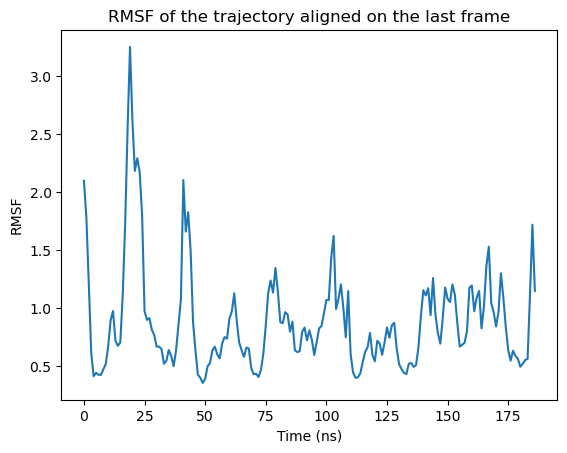

In [9]:
RF = RMSF(aligned_traj.select_atoms(sel)).run()

plt.title('RMSF of the trajectory aligned on the last frame')
plt.plot(RF.results.rmsf)
plt.xlabel('Time (ns)')
plt.ylabel('RMSF')

Text(0, 0.5, 'RMSF')

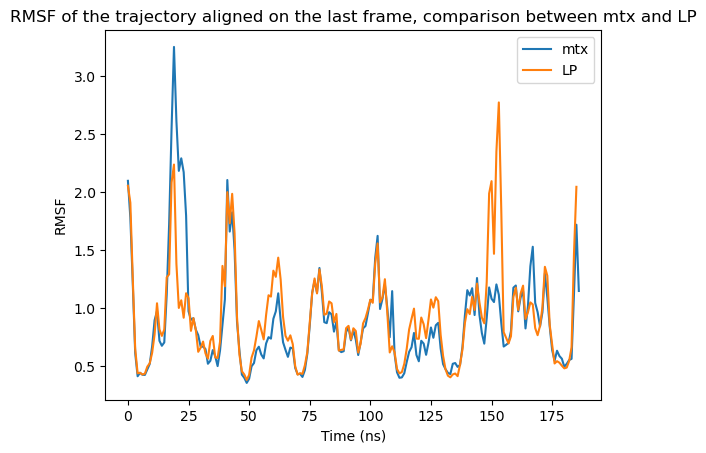

In [10]:
# comparison with lone protein
LP_path = "../../data/02_processed/02_prod/rmsf.csv"
LP_rmsf = pd.read_csv(LP_path)

plt.title('RMSF of the trajectory aligned on the last frame, comparison between mtx and LP')
plt.plot(RF.results.rmsf, label = "mtx")
plt.plot(LP_rmsf["rmsf"], label = "LP")
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('RMSF')

Principal Component Analysis 

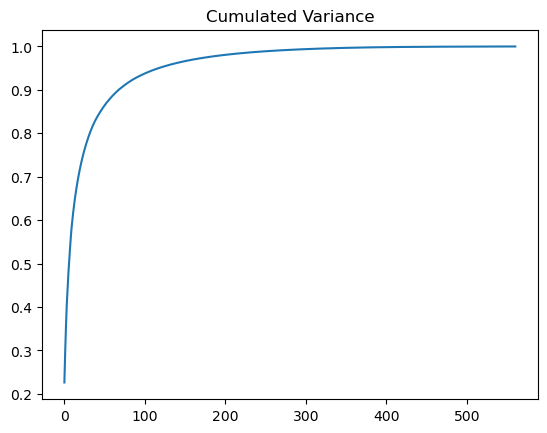

In [11]:
pca = PCA(aligned_traj, select=sel)
pca.run()


plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [12]:
pca_space = pca.transform(conc_traj.select_atoms(sel),2)
pca_data = pd.DataFrame(pca_space, columns=['first_comp','second_comp'])
pca_data["group"] = pca_data.index // 40

,first_comp,second_comp,group
0,-3.658519,1.591723,0
1,-4.006934,0.361867,0
2,-2.802838,-1.343065,0
3,-4.136621,-3.697594,0
4,-5.289377,-2.720405,0
...,...,...,...
1698,5.785482,17.757223,42
1699,6.485345,20.978059,42
1700,6.356467,20.558582,42
1701,8.831057,11.853054,42


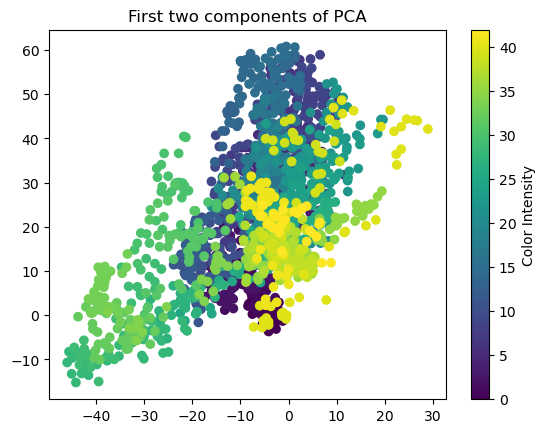

In [13]:
plt.title("First two components of PCA")
scatter = plt.scatter(pca_data['first_comp'], pca_data['second_comp'], c=pca_data['group'])
plt.colorbar(scatter, label = 'Color Intensity')

                                                    Radius of Gyration 

Text(0, 0.5, 'Radius of Gyration')

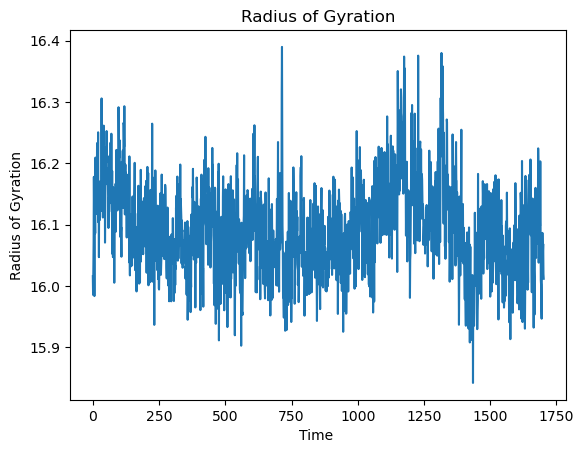

In [14]:
atom_group = aligned_traj.select_atoms(sel)

radii_o_gyr = []

for ts in aligned_traj.trajectory:
    rg = atom_group.radius_of_gyration()
    radii_o_gyr.append(rg)

plt.title('Radius of Gyration')
plt.plot(radii_o_gyr)
plt.xlabel('Time ')
plt.ylabel('Radius of Gyration')

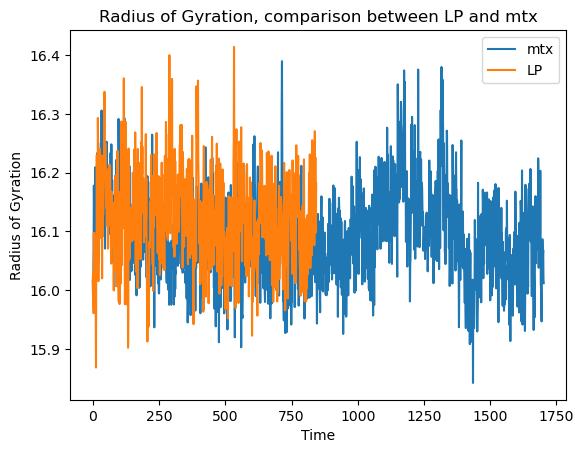

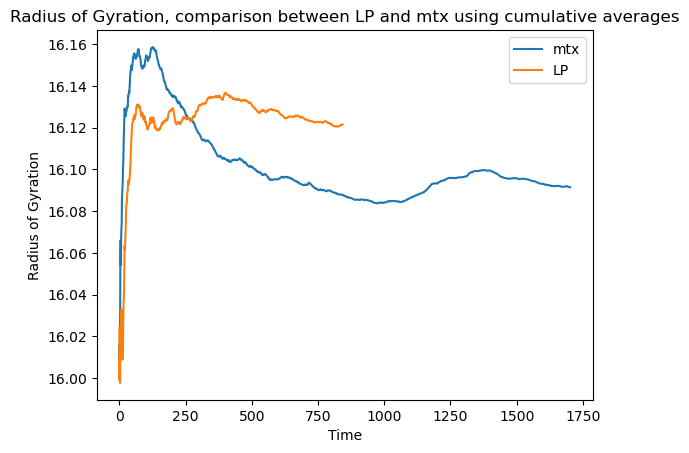

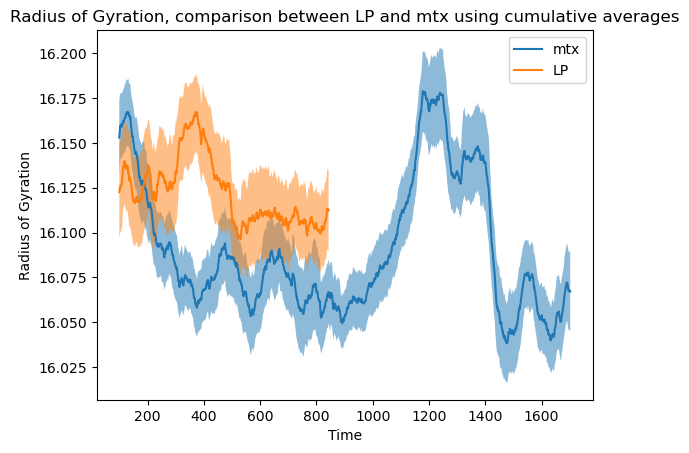

In [29]:
# comparison with lone protein
LP_path = "../../data/02_processed/02_prod/rgyr.csv"
LP_rgyr = pd.read_csv(LP_path)

plt.title('Radius of Gyration, comparison between LP and mtx')
plt.plot(radii_o_gyr, label = "mtx")
plt.plot(LP_rgyr['rgyr'], label = "LP")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Radius of Gyration')
plt.show()

rg_mtx_df = pd.DataFrame({"rgyr": radii_o_gyr})

plt.title('Radius of Gyration, comparison between LP and mtx using cumulative averages')
plt.plot(rg_mtx_df.expanding().mean(), label = "mtx")
plt.plot(LP_rgyr['rgyr'].expanding().mean(), label = "LP")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Radius of Gyration')
plt.show()

err_LP = np.sqrt(LP_rgyr.rolling(100).var()["rgyr"] / 10)
mean_LP = LP_rgyr.rolling(100).mean()["rgyr"] 
err_MTX = np.sqrt(rg_mtx_df.rolling(100).var()["rgyr"] / 10)
mean_MTX = rg_mtx_df.rolling(100).mean()["rgyr"] 
plt.title('Radius of Gyration, comparison between LP and mtx using cumulative averages')
plt.plot(mean_MTX, label = "mtx")
plt.fill_between(rg_mtx_df.index, mean_MTX - err_MTX, mean_MTX + err_MTX, alpha = 0.5)
plt.plot(mean_LP, label = "LP")
plt.fill_between(LP_rgyr.index, mean_LP - err_LP, mean_LP + err_LP, alpha = 0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Radius of Gyration')
plt.show()

# We may want to check for the radius of gyration only of the "interaction pocket" of the protein

# Clustering

First we need to reduce the number of frames

In [53]:
sampled_traj_name = data_path + 'sampled_traj_each10.xtc'

with mda.Writer(sampled_traj_name, n_atoms=aligned_traj.atoms.n_atoms) as w:
    for ts in aligned_traj.trajectory[::2]:
        w.write(aligned_traj.atoms)

In [54]:
sampled_traj = mda.Universe(config_file, sampled_traj_name)
sampled_traj.trajectory.n_frames
sampled_ref_traj = mda.Universe(config_file, sampled_traj_name)
sampled_ref_traj.trajectory[-1]

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


< Timestep 851 with unit cell dimensions [71.15754 71.15754 71.15754 90.      90.      90.     ] >

Text(0, 0.5, 'RMSD')

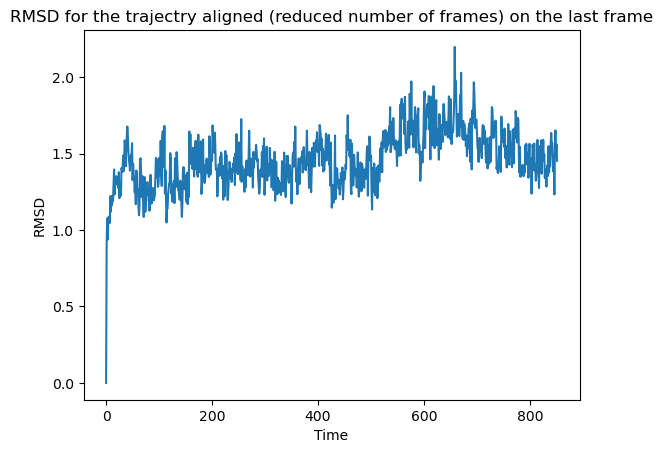

In [55]:
R = RMSD(sampled_traj, sampled_ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned (reduced number of frames) on the last frame")
plt.plot(R.results.rmsd[:,2])
plt.xlabel('Time')
plt.ylabel('RMSD')

In [56]:
matrix = diffusionmap.DistanceMatrix(sampled_traj, select=sel).run()

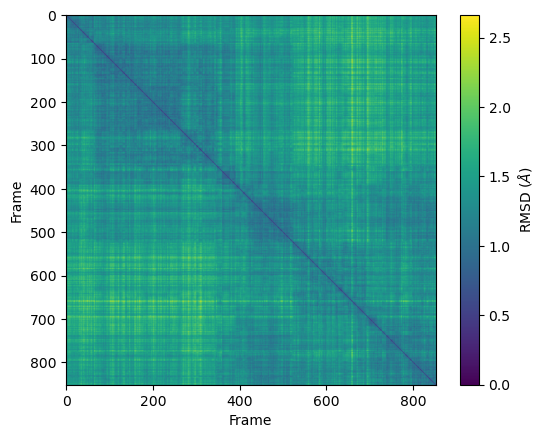

In [57]:
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

In [58]:
Z = linkage(squareform(matrix.results.dist_matrix), 'average')

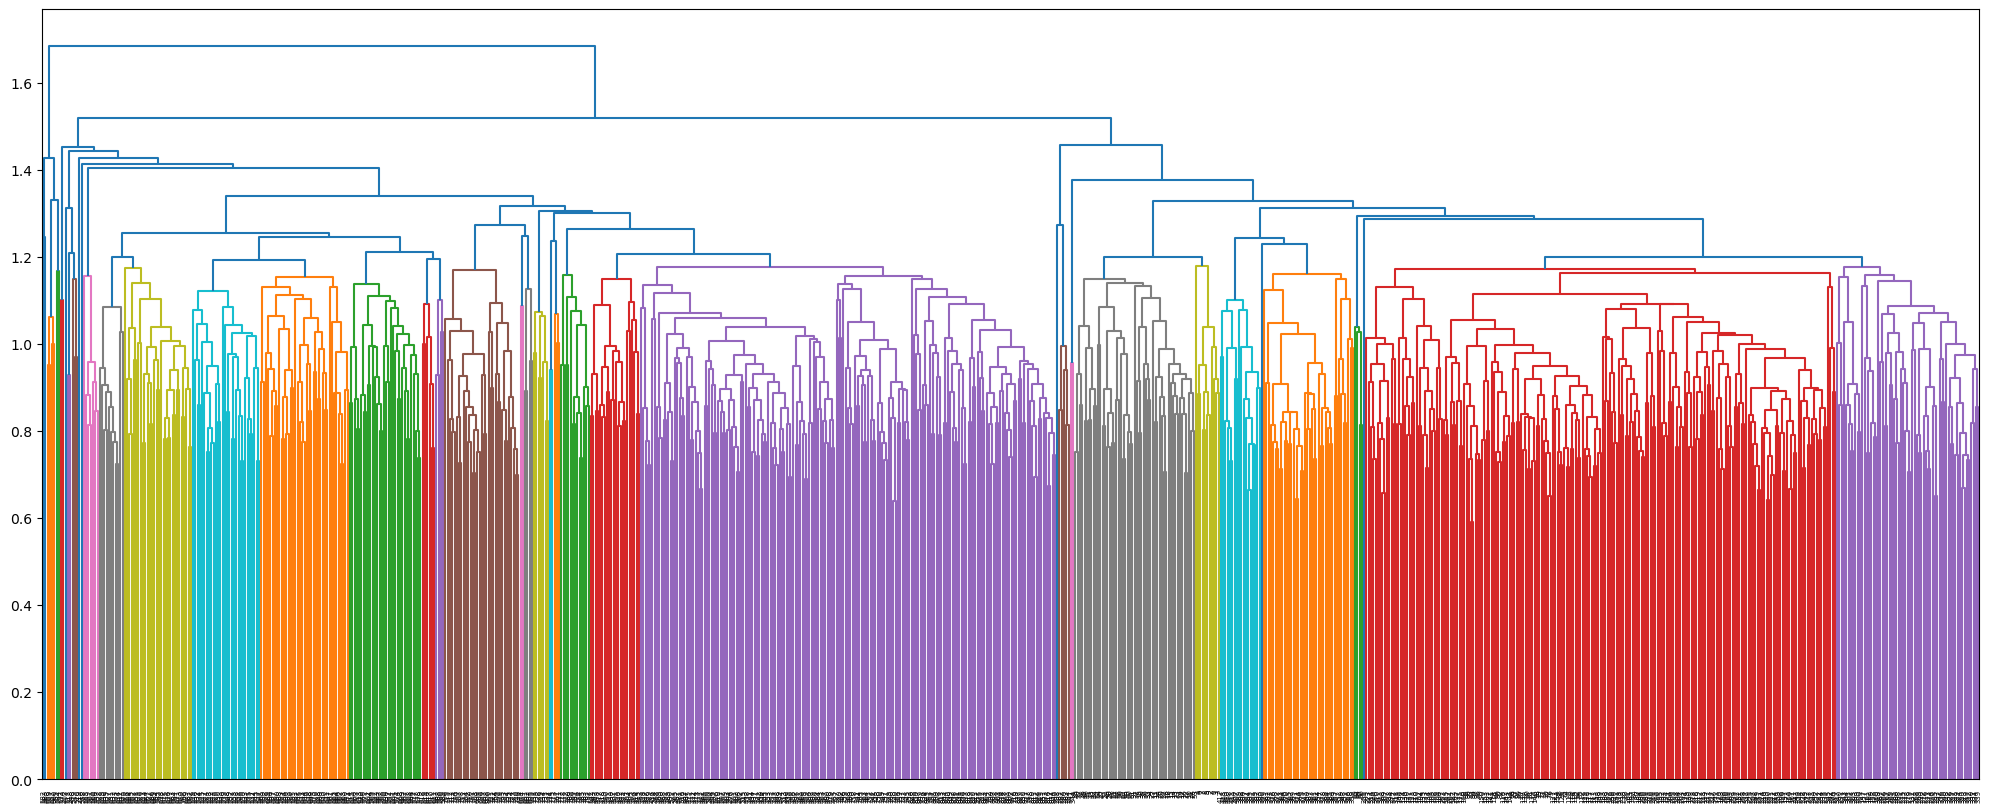

In [59]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [60]:
cl_labels = fcluster(Z, t=4, criterion='maxclust')

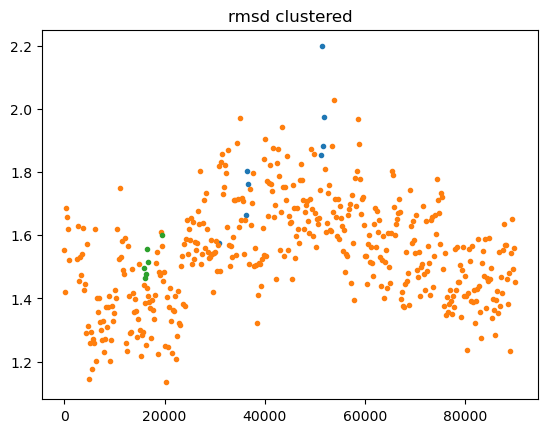

In [61]:
rmsd_arr = R.results.rmsd
plt.plot(rmsd_arr[cl_labels == 1][:, 1], rmsd_arr[cl_labels == 1][:, 2], '.')
plt.plot(rmsd_arr[cl_labels == 2][:, 1], rmsd_arr[cl_labels == 2][:, 2], '.')
plt.plot(rmsd_arr[cl_labels == 3][:, 1], rmsd_arr[cl_labels == 3][:, 2], '.')
plt.title("rmsd clustered")
plt.show()